In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class, get_dataloader
from src.preprocessing.sequence_classification.set_fit_dataset import SetFitDataset
from src.model.sequence_classification.setfit_trainer import SetFitTrainer
from src.model.sequence_classification.trainer import SequenceClassificationTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
!mkdir logs
model_name = "SetFit"
dataset_name = "SST5"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
# logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


In [4]:
notebook_login()

In [4]:
model = SentenceTransformer("whaleloops/phrase-bert")

In [5]:
try:
    from torch.hub import _get_torch_home

    torch_cache_home = _get_torch_home()
except ImportError:
    torch_cache_home = os.path.expanduser(os.getenv('TORCH_HOME', os.path.join(os.getenv('XDG_CACHE_HOME', '~/.cache'), 'torch')))

cache_folder = os.path.join(torch_cache_home, 'sentence_transformers')

In [6]:
cache_folder

'/users/eleves-a/2022/pedro.silva/.cache/torch/sentence_transformers'

## Loading SST5 data

In [4]:
sst5_dataset = load_dataset("SetFit/sst5")

In [5]:
classes = np.unique(sst5_dataset['train']['label'], return_counts=True)
classes

(array([0, 1, 2, 3, 4]), array([1092, 2218, 1624, 2322, 1288]))

In [6]:
num_classes = len(classes[0])

In [7]:
num_classes

5

In [8]:
data_size = len(sst5_dataset['train'])
data_size

8544

In [9]:
train_text = sst5_dataset['train']['text'][0:data_size*3//5]
train_labels = sst5_dataset['train']['label'][0:data_size*3//5]

val_text = sst5_dataset['train']['text'][data_size*3//5:]
val_labels = sst5_dataset['train']['label'][data_size*3//5:]

## Normal Finetune

In [14]:
bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = num_classes)\
    .to(device)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
train_dataloader = get_dataloader(
    train_text,
    train_labels,
    tokenizer,
    n_shots = 200,
    num_classes= num_classes,
    equalize_class=False,
    batch_size = 8
)

val_dataloader = get_dataloader(
    val_text,
    val_labels,
    tokenizer,
    n_shots = 100,
    equalize_class=False,
    num_classes=num_classes
)

In [16]:
train_dataloader.dataset[0:]

{'input_ids': tensor([[  101,  1037, 18385,  ...,     0,     0,     0],
         [  101,  4593,  2128,  ...,     0,     0,     0],
         [  101,  2027,  3653,  ...,     0,     0,     0],
         ...,
         [  101,  1998,  2111,  ...,     0,     0,     0],
         [  101,  1996,  4616,  ...,     0,     0,     0],
         [  101,  1012,  1012,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([4, 1, 1, 2, 3, 2, 3, 3, 1, 4, 1, 1, 3, 1, 1, 4, 3, 3, 1, 4, 0, 1, 1, 4,
         1, 2, 1, 2, 0, 3, 4, 1, 4, 1, 2, 1, 2, 2, 3, 2, 3, 3, 2, 2, 3, 1, 2, 2,
         2, 2, 1, 1, 4, 3, 3, 2, 3, 3, 1, 4, 0, 3, 3, 3, 4, 1, 2, 3, 4, 4, 2, 0,
         3, 0, 3, 2, 4, 2, 3, 4, 3, 3, 3, 4, 1, 0, 0, 2, 4, 3, 1, 4, 3, 3, 4, 2,
         4, 3, 1, 1, 2, 1, 1, 4, 1, 1, 

In [17]:
np.unique(
    train_dataloader.dataset[0:]['labels'],
    return_counts= True

)

(array([0, 1, 2, 3, 4]), array([132, 261, 174, 279, 154]))

In [19]:
histories = {}

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

for i in range(6):

    bert = AutoModelForSequenceClassification\
        .from_pretrained("bert-base-uncased", num_labels = num_classes)\
        .to(device)

    trainer = SequenceClassificationTrainer(
        bert,
        num_classes
    )
    n_shots = 100//2**i
    
    train_dataloader = get_dataloader(
        train_text,
        train_labels,
        tokenizer,
        n_shots= n_shots,
        num_classes= num_classes,
        shuffle = True,
        worker_init_fn=seed_worker,
        generator=g
    )

    val_dataloader = get_dataloader(
        val_text,
        val_labels,
        tokenizer,
        n_shots = 250,
        num_classes=num_classes,
        equalize_class=False
    )

    history = trainer.compile(
        train_dataloader,
        val_dataloader,
        n_epochs=10
    )

    histories[100//2**i] = history

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 500/500 [00:22<00:00, 22.15it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 250/250 [00:11<00:00, 22.17it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 125/

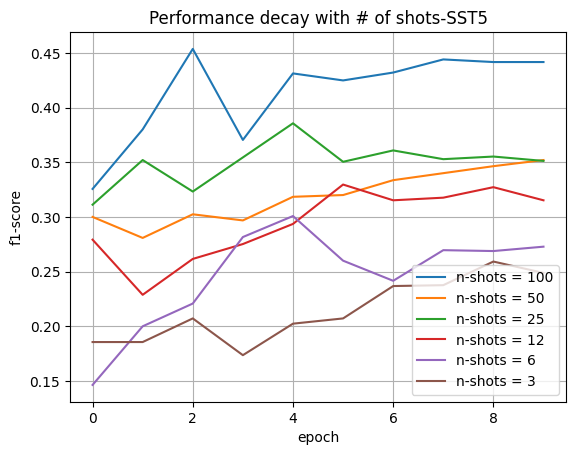

In [20]:
results = {}
for k, v in histories.items():
    plt.plot(v['val_f1'],
             label = f"n-shots = {k}")
    
plt.title("Performance decay with # of shots-SST5")
    
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.show()

## 2 Shots

In [13]:
n_shots =2 

In [14]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)

In [15]:
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 10,
    num_classes=num_classes
)

In [16]:
set_fit_data_train = SetFitDataset(
    X_train,
    y_train, 
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    X_val,
    y_val,
    # R = 5,
    input_example_format= False
)

In [17]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

### Train embedding

In [19]:
model = SentenceTransformer("whaleloops/phrase-bert")
loss_fn = losses.CosineSimilarityLoss(model)
cos_sim = torch.nn.CosineSimilarity(dim = 1)

n_epochs = 10
best_f1 = 0
best_model = None

for epoch in range(n_epochs):
    model.fit(
        train_objectives=[ (train_dataloader, loss_fn)],
        epochs = 1,
        show_progress_bar=False
    )

    y_true_val = torch.tensor([],device=device)
    y_pred_val = torch.tensor([],device=device)

    print(f"Running validation after {epoch} epochs")

    for [x1, x2, y] in tqdm(val_dataloader):
        with torch.no_grad():
            v1 = model.encode(x1, convert_to_tensor= True)
            v2 = model.encode(x2, convert_to_tensor= True)

            cos = cos_sim(v1, v2)

            y_pred = round(cos.item())
            y_true = y

            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([y_true]).to(device)
            ])
            
    f1 = binary_f1_score(
        y_pred_val,
        y_true_val,
    )
    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(model)

    conf_matrix= multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes=2
    )

    print(f'f1 score: {f1.item()}')
    print(conf_matrix)

best_model.save_to_hub(f"peulsilva/phrase-bert-setfit-sst5-{n_shots}shots")

Running validation after 0 epochs


100%|██████████| 1225/1225 [00:08<00:00, 139.07it/s]


f1 score: 0.30127662420272827
tensor([[227, 773],
        [ 48, 177]], device='cuda:0')
Running validation after 1 epochs


100%|██████████| 1225/1225 [00:08<00:00, 138.81it/s]


f1 score: 0.29871243238449097
tensor([[234, 766],
        [ 51, 174]], device='cuda:0')
Running validation after 2 epochs


100%|██████████| 1225/1225 [00:08<00:00, 137.89it/s]


f1 score: 0.2970638871192932
tensor([[239, 761],
        [ 53, 172]], device='cuda:0')
Running validation after 3 epochs


100%|██████████| 1225/1225 [00:08<00:00, 136.62it/s]


f1 score: 0.2986111044883728
tensor([[245, 755],
        [ 53, 172]], device='cuda:0')
Running validation after 4 epochs


100%|██████████| 1225/1225 [00:08<00:00, 136.74it/s]


f1 score: 0.29649123549461365
tensor([[254, 746],
        [ 56, 169]], device='cuda:0')
Running validation after 5 epochs


100%|██████████| 1225/1225 [00:08<00:00, 137.73it/s]


f1 score: 0.29427313804626465
tensor([[257, 743],
        [ 58, 167]], device='cuda:0')
Running validation after 6 epochs


100%|██████████| 1225/1225 [00:08<00:00, 136.84it/s]


f1 score: 0.29081180691719055
tensor([[267, 733],
        [ 62, 163]], device='cuda:0')
Running validation after 7 epochs


100%|██████████| 1225/1225 [00:08<00:00, 137.23it/s]


f1 score: 0.2887892425060272
tensor([[271, 729],
        [ 64, 161]], device='cuda:0')
Running validation after 8 epochs


100%|██████████| 1225/1225 [00:08<00:00, 136.79it/s]


f1 score: 0.2862318754196167
tensor([[279, 721],
        [ 67, 158]], device='cuda:0')
Running validation after 9 epochs


100%|██████████| 1225/1225 [00:08<00:00, 137.62it/s]


f1 score: 0.28545287251472473
tensor([[288, 712],
        [ 69, 156]], device='cuda:0')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning https://huggingface.

Upload file model.safetensors:   0%|          | 1.00/418M [00:00<?, ?B/s]

To https://huggingface.co/peulsilva/phrase-bert-setfit-sst5-2shots
   139b537..18efeb5  main -> main

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/peulsilva/phrase-bert-setfit-sst5-2shots/commit/18efeb551b53825356316dbe1eed7d1e4efe4074'

### Training classifier 

In [20]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [21]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 100,
    num_classes=num_classes
)

In [22]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff

In [23]:
X_train_shuffled , y_train_shuffled = shuffle_two_lists(X_train, y_train)

In [24]:
from IPython.display import clear_output

In [25]:
embedding_model = SentenceTransformer(f"peulsilva/phrase-bert-setfit-sst5-{n_shots}shots")\
    .to(device)

in_features = embedding_model.get_sentence_embedding_dimension()
clf = CLF(
    in_features,
    num_classes,
).to(device)


loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    clf.parameters(),
    lr = 1e-5
)

best_model = None
best_f1 = 0
n_epochs = 100

history = []

for epoch in (range(n_epochs)):
    for i in tqdm(range(len(X_train))):
        text = X_train_shuffled[i]
        label = torch.tensor(y_train_shuffled[i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

        optimizer.zero_grad()
        output = clf(embedding)
        loss = loss_fn(output, label)


        loss.backward()
        optimizer.step()

    y_true_val = torch.tensor([],device=device)
    y_pred_val = torch.tensor([],device=device)

    for i in range(len(X_val)):
        text = X_val[i]
        label = torch.tensor(y_val[i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

            y_pred = clf(embedding)\
                .argmax()
            
            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([y_val[i]]).to(device)
            ])
            
    f1 = multiclass_f1_score(
        y_pred_val,
        y_true_val,
        num_classes=num_classes
    )
    
    history.append(f1.item())
    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(clf)

    conf_matrix= multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes=num_classes
    )

    clear_output()
    print(f"---------Epoch: {epoch}-----------")
    print(f'f1 score: {f1.item()}')
    print(conf_matrix)

---------Epoch: 99-----------
f1 score: 0.2280000001192093
tensor([[ 8, 40, 18, 26,  8],
        [22, 35, 14, 21,  8],
        [16, 40, 11, 25,  8],
        [10, 28, 12, 32, 18],
        [ 7, 14, 12, 39, 28]], device='cuda:0')


In [30]:
best_epoch = 0
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [31]:
best_epoch

18

Text(0.5, 1.0, 'SetFit training results- SST5 - 2 shots')

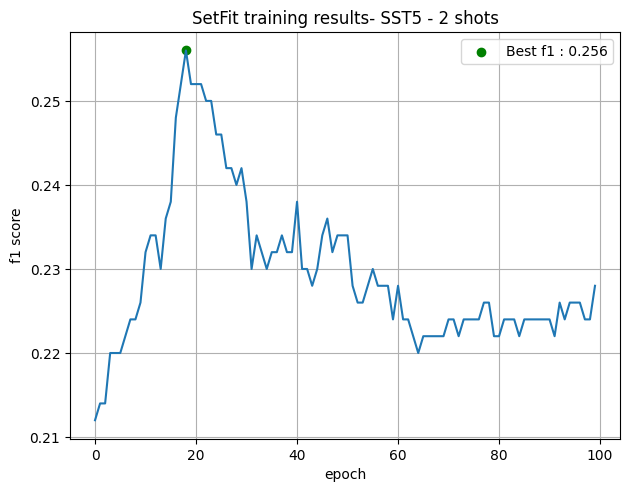

In [32]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title("SetFit training results- SST5 - 2 shots")

## 5 shots

In [39]:
n_shots = 5

In [40]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)

In [41]:
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 10,
    num_classes=num_classes
)

In [42]:
set_fit_data_train = SetFitDataset(
    X_train,
    y_train, 
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    X_val,
    y_val,
    # R = 5,
    input_example_format= False
)

In [43]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

### Train embedding

In [44]:
model = SentenceTransformer("whaleloops/phrase-bert")
loss_fn = losses.CosineSimilarityLoss(model)
cos_sim = torch.nn.CosineSimilarity(dim = 1)

n_epochs = 10
best_f1 = 0
best_model = None

for epoch in range(n_epochs):
    model.fit(
        train_objectives=[ (train_dataloader, loss_fn)],
        epochs = 1,
        show_progress_bar=False
    )

    y_true_val = torch.tensor([],device=device)
    y_pred_val = torch.tensor([],device=device)

    print(f"Running validation after {epoch} epochs")

    for [x1, x2, y] in tqdm(val_dataloader):
        with torch.no_grad():
            v1 = model.encode(x1, convert_to_tensor= True)
            v2 = model.encode(x2, convert_to_tensor= True)

            cos = cos_sim(v1, v2)

            y_pred = round(cos.item())
            y_true = y

            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([y_true]).to(device)
            ])
            
    f1 = binary_f1_score(
        y_pred_val,
        y_true_val,
    )
    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(model)

    conf_matrix= multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes=2
    )

    print(f'f1 score: {f1.item()}')
    print(conf_matrix)

best_model.save_to_hub(f"peulsilva/phrase-bert-setfit-sst5-{n_shots}shots")

Running validation after 0 epochs


100%|██████████| 1225/1225 [00:08<00:00, 138.60it/s]


f1 score: 0.24581004679203033
tensor([[597, 403],
        [137,  88]], device='cuda:0')
Running validation after 1 epochs


100%|██████████| 1225/1225 [00:08<00:00, 136.19it/s]


f1 score: 0.16267941892147064
tensor([[841, 159],
        [191,  34]], device='cuda:0')
Running validation after 2 epochs


100%|██████████| 1225/1225 [00:09<00:00, 135.97it/s]


f1 score: 0.10158730298280716
tensor([[926,  74],
        [209,  16]], device='cuda:0')
Running validation after 3 epochs


100%|██████████| 1225/1225 [00:08<00:00, 136.20it/s]


f1 score: 0.07352941483259201
tensor([[963,  37],
        [215,  10]], device='cuda:0')
Running validation after 4 epochs


100%|██████████| 1225/1225 [00:09<00:00, 135.37it/s]


f1 score: 0.05511811003088951
tensor([[978,  22],
        [218,   7]], device='cuda:0')
Running validation after 5 epochs


100%|██████████| 1225/1225 [00:08<00:00, 136.47it/s]


f1 score: 0.04838709905743599
tensor([[983,  17],
        [219,   6]], device='cuda:0')
Running validation after 6 epochs


100%|██████████| 1225/1225 [00:09<00:00, 135.38it/s]


f1 score: 0.032786887139081955
tensor([[985,  15],
        [221,   4]], device='cuda:0')
Running validation after 7 epochs


100%|██████████| 1225/1225 [00:09<00:00, 135.42it/s]


f1 score: 0.03292180970311165
tensor([[986,  14],
        [221,   4]], device='cuda:0')
Running validation after 8 epochs


100%|██████████| 1225/1225 [00:09<00:00, 134.76it/s]


f1 score: 0.02489626407623291
tensor([[987,  13],
        [222,   3]], device='cuda:0')
Running validation after 9 epochs


100%|██████████| 1225/1225 [00:09<00:00, 134.70it/s]


f1 score: 0.01666666753590107
tensor([[987,  13],
        [223,   2]], device='cuda:0')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning https://huggingface.

Upload file model.safetensors:   0%|          | 1.00/418M [00:00<?, ?B/s]

To https://huggingface.co/peulsilva/phrase-bert-setfit-sst5-5shots
   fcbddfe..03c9d06  main -> main

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/peulsilva/phrase-bert-setfit-sst5-5shots/commit/03c9d0641f4c3713f87fba2cdf80a1f17ac4a707'

### Training classifier 

In [45]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [46]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 100,
    num_classes=num_classes
)

In [47]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff

In [48]:
X_train_shuffled , y_train_shuffled = shuffle_two_lists(X_train, y_train)

In [49]:
from IPython.display import clear_output

In [50]:
embedding_model = SentenceTransformer(f"peulsilva/phrase-bert-setfit-sst5-{n_shots}shots")\
    .to(device)

in_features = embedding_model.get_sentence_embedding_dimension()
clf = CLF(
    in_features,
    num_classes,
).to(device)


loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    clf.parameters(),
    lr = 1e-5
)

best_model = None
best_f1 = 0
n_epochs = 100

history = []

for epoch in (range(n_epochs)):
    for i in tqdm(range(len(X_train))):
        text = X_train_shuffled[i]
        label = torch.tensor(y_train_shuffled[i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

        optimizer.zero_grad()
        output = clf(embedding)
        loss = loss_fn(output, label)


        loss.backward()
        optimizer.step()

    y_true_val = torch.tensor([],device=device)
    y_pred_val = torch.tensor([],device=device)

    for i in range(len(X_val)):
        text = X_val[i]
        label = torch.tensor(y_val[i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

            y_pred = clf(embedding)\
                .argmax()
            
            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([y_val[i]]).to(device)
            ])
            
    f1 = multiclass_f1_score(
        y_pred_val,
        y_true_val,
        num_classes=num_classes
    )
    
    history.append(f1.item())
    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(clf)

    conf_matrix= multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes=num_classes
    )

    clear_output()
    print(f"---------Epoch: {epoch}-----------")
    print(f'f1 score: {f1.item()}')
    print(conf_matrix)

---------Epoch: 99-----------
f1 score: 0.27799999713897705
tensor([[23, 22, 34, 20,  1],
        [24, 20, 30, 21,  5],
        [27, 15, 28, 23,  7],
        [10, 10, 30, 28, 22],
        [ 8,  9, 26, 17, 40]], device='cuda:0')


In [54]:
best_epoch = 0
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [55]:
best_epoch

36

Text(0.5, 1.0, 'SetFit training results- SST5 - 5 shots')

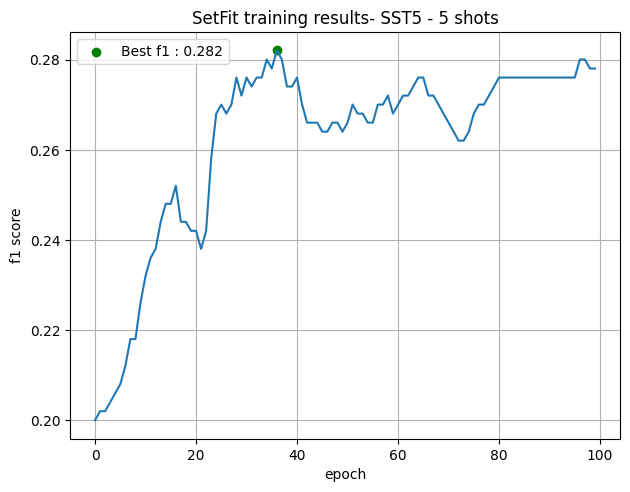

In [56]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title("SetFit training results- SST5 - 5 shots")

## 10 shots

In [57]:
n_shots = 10

In [58]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)

In [59]:
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 10,
    num_classes=num_classes
)

In [60]:
set_fit_data_train = SetFitDataset(
    X_train,
    y_train, 
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    X_val,
    y_val,
    # R = 5,
    input_example_format= False
)

In [61]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

### Train embedding

In [ ]:
model = SentenceTransformer("whaleloops/phrase-bert")
loss_fn = losses.CosineSimilarityLoss(model)
cos_sim = torch.nn.CosineSimilarity(dim = 1)

n_epochs = 50
best_f1 = 0
best_model = None

for epoch in range(n_epochs):
    model.fit(
        train_objectives=[ (train_dataloader, loss_fn)],
        epochs = 1,
        show_progress_bar=False
    )

    y_true_val = torch.tensor([],device=device)
    y_pred_val = torch.tensor([],device=device)

    print(f"Running validation after {epoch} epochs")

    for [x1, x2, y] in tqdm(val_dataloader):
        with torch.no_grad():
            v1 = model.encode(x1, convert_to_tensor= True)
            v2 = model.encode(x2, convert_to_tensor= True)

            cos = cos_sim(v1, v2)

            y_pred = round(cos.item())
            y_true = y

            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([y_true]).to(device)
            ])
            
    f1 = binary_f1_score(
        y_pred_val,
        y_true_val,
    )
    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(model)

    conf_matrix= multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes=2
    )

    print(f'f1 score: {f1.item()}')
    print(conf_matrix)

best_model.save_to_hub(f"peulsilva/phrase-bert-setfit-sst5-{n_shots}shots")

### Training classifier 

In [13]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [14]:
X_train, y_train = get_n_shots_per_class(
    train_text,
    train_labels,
    n_shots= n_shots,
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_text, 
    val_labels,
    n_shots = 100,
    num_classes=num_classes
)

In [17]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff

In [18]:
X_train_shuffled , y_train_shuffled = shuffle_two_lists(X_train, y_train)

In [19]:
from IPython.display import clear_output

In [20]:
embedding_model = SentenceTransformer(f"peulsilva/phrase-bert-setfit-sst5-{n_shots}shots")\
    .to(device)

in_features = embedding_model.get_sentence_embedding_dimension()
clf = CLF(
    in_features,
    num_classes,
).to(device)


loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    clf.parameters(),
    lr = 1e-5
)

best_model = None
best_f1 = 0
n_epochs = 100

history = []

for epoch in (range(n_epochs)):
    for i in tqdm(range(len(X_train))):
        text = X_train_shuffled[i]
        label = torch.tensor(y_train_shuffled[i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

        optimizer.zero_grad()
        output = clf(embedding)
        loss = loss_fn(output, label)


        loss.backward()
        optimizer.step()

    y_true_val = torch.tensor([],device=device)
    y_pred_val = torch.tensor([],device=device)

    for i in range(len(X_val)):
        text = X_val[i]
        label = torch.tensor(y_val[i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

            y_pred = clf(embedding)\
                .argmax()
            
            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([y_val[i]]).to(device)
            ])
            
    f1 = multiclass_f1_score(
        y_pred_val,
        y_true_val,
        num_classes=num_classes
    )
    
    history.append(f1.item())
    if f1 > best_f1:
        best_f1 = f1
        best_model = deepcopy(clf)

    conf_matrix= multiclass_confusion_matrix(
        y_pred_val.to(torch.int64),
        y_true_val.to(torch.int64),
        num_classes=num_classes
    )

    clear_output()
    print(f"---------Epoch: {epoch}-----------")
    print(f'f1 score: {f1.item()}')
    print(conf_matrix)

---------Epoch: 99-----------
f1 score: 0.3319999873638153
tensor([[43, 17, 16, 16,  8],
        [36, 10, 18, 30,  6],
        [17, 24, 16, 36,  7],
        [ 9,  7, 15, 49, 20],
        [ 5,  9, 12, 26, 48]], device='cuda:0')


In [21]:
best_epoch = 0
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [22]:
best_epoch

2

Text(0.5, 1.0, 'SetFit training results- SST5 - 10 shots')

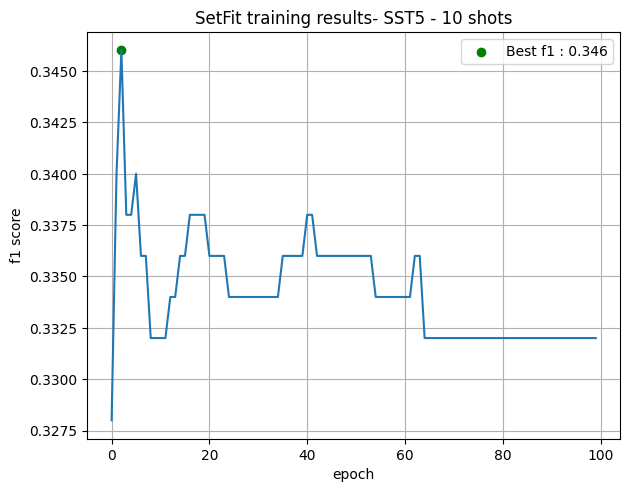

In [23]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title(f"SetFit training results- SST5 - {n_shots} shots")